# Traces for the previous choice datan
Here we use the components extracted in the previous step and the timestamped data from the behavior

In [25]:
# Load the libraries
import caiman as cm
from caiman.source_extraction import cnmf

import matplotlib.pyplot as plt
from matplotlib.widgets import Button, TextBox
from matplotlib.patches import Polygon
from matplotlib.path import Path
import matplotlib.gridspec as gridspec
from matplotlib.widgets import CheckButtons

import numpy as np
import pandas as pd
import json
from scipy.sparse import csc_matrix
from scipy.stats import sem
from scipy import stats

from IPython import get_ipython
import IPython

import math

from ipyfilechooser import FileChooser

from scipy.ndimage import binary_erosion

try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the data

In [11]:
# Load the data
path = 'D:/CaIm/os70/'

neu_path = path + 'good_neu_traces.csv'

neuron_traces = pd.read_csv(neu_path)
neuron_traces = neuron_traces.to_numpy()

In [4]:
# Load event times
# Create and display a FileChooser widget
fc = FileChooser('D:/behav/')
fc.filter_pattern = '*.csv'
fc.use_dir_icons = True
display(fc)

FileChooser(path='D:\behav', filename='', title='', show_hidden=False, select_desc='Select', change_desc='Chan…

In [6]:
file_path = fc.selected_path + '\\' + fc.selected_filename
data = pd.read_csv(file_path)
data_licks_L = pd.read_csv(file_path[0:-4] + '_t_licks_L.csv', header = None)
data_licks_R = pd.read_csv(file_path[0:-4] + '_t_licks_R.csv', header = None)

#data = data[data['laser_stim_ts']!=0]
#data['end_trial'] = data['laser_stim_ts'].shift(-1) 
#data['end_trial'].fillna( data['laser_stim_ts'][data.shape[0]-1] + 6000, inplace=True)


In [7]:
data['tone_ts'][0]

-2163

In [8]:
if data['tone_ts'][1] < 0:
    data['tone_ts'] = [ -x for x in data['tone_ts'] ]
data

,missed,laser,side,tone_ts,choice,free
0,0,0,-1,2163,-1,0
1,0,0,1,5941,-1,0
2,1,0,1,11098,0,0
3,1,0,-1,15557,0,0
4,1,2,1,20004,0,0
...,...,...,...,...,...,...
245,0,1,1,1007431,1,0
246,0,0,-1,1011224,-1,0
247,0,2,-1,1015223,-1,0
248,0,2,1,1019026,1,0


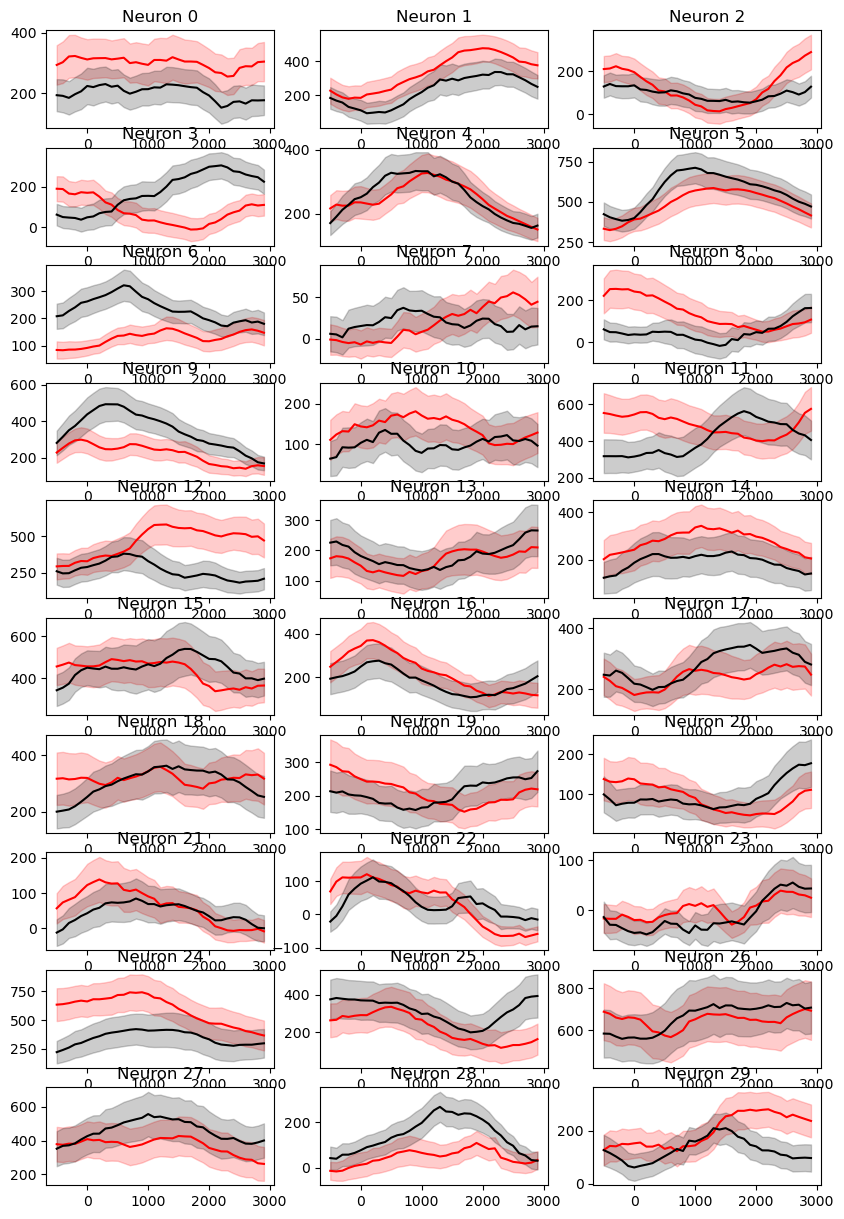

In [12]:


# Example DataFrames
# neuron_traces = pd.DataFrame(...)  # Your neuron traces data
# data = pd.DataFrame(...)  # Your laser event data

# Sample neuron to plot
#neuron_id = 2  # Adjust this based on the neuron you want to plot

# Time conversion
sampling_rate = 10  # Hz
pre_event_points = 500 // (1000 / sampling_rate)  # 500 ms before
post_event_points = 3000 // (1000 / sampling_rate)  # 3000 ms after

# Function to extract data around laser event
def extract_data(side, n_id):
    times = data[data['side'] == side]['tone_ts']
    indices = (times * sampling_rate / 1000).astype(int)
    traces = []
    for idx in indices:
        start = int(idx - pre_event_points)
        end = int( idx + post_event_points)
        if start > 500 & end < neuron_traces.shape[1]-1:
            trace = neuron_traces[n_id, start:end]
            if trace.shape[0] == pre_event_points + post_event_points:
                traces.append(trace)
    return np.array(traces)


def plot_neu(neuron_id, ax_n):
    for i in [0,1,2]:
        # Extract data for each laser type
        traces_1 = extract_data(1, neuron_id+i)

        traces_0 = extract_data(-1, neuron_id+i)
        # Mean and std
        mean_trace_1 = np.mean(traces_1, axis=0)
        std_trace_1 = sem(traces_1, axis=0)

        mean_trace_0 = np.mean(traces_0, axis=0)
        std_trace_0 = sem(traces_0, axis=0)
        # Laser = 1
        axs[ax_n,i].plot(time_points, mean_trace_1, color='r', label='Mean')
        axs[ax_n,i].fill_between(time_points, mean_trace_1 - std_trace_1, mean_trace_1 + std_trace_1, color='r', alpha=0.2)

        # Laser = 0
        axs[ax_n,i].plot(time_points, mean_trace_0, color='k', label='Mean')
        axs[ax_n,i].fill_between(time_points, mean_trace_0 - std_trace_0, mean_trace_0 + std_trace_0, color='k', alpha=0.2)
        axs[ax_n,i].set_title('Neuron '+ str(neuron_id+i))



# Time points for x-axis
time_points = np.arange(-pre_event_points, post_event_points) * (1000 / sampling_rate)

# Plotting
fig, axs = plt.subplots(10, 3, figsize=(10, 15))
neu_indx = np.arange(0,30,3)
for n in np.arange(len(neu_indx)):
    plot_neu(neu_indx[n], n)


plt.show()






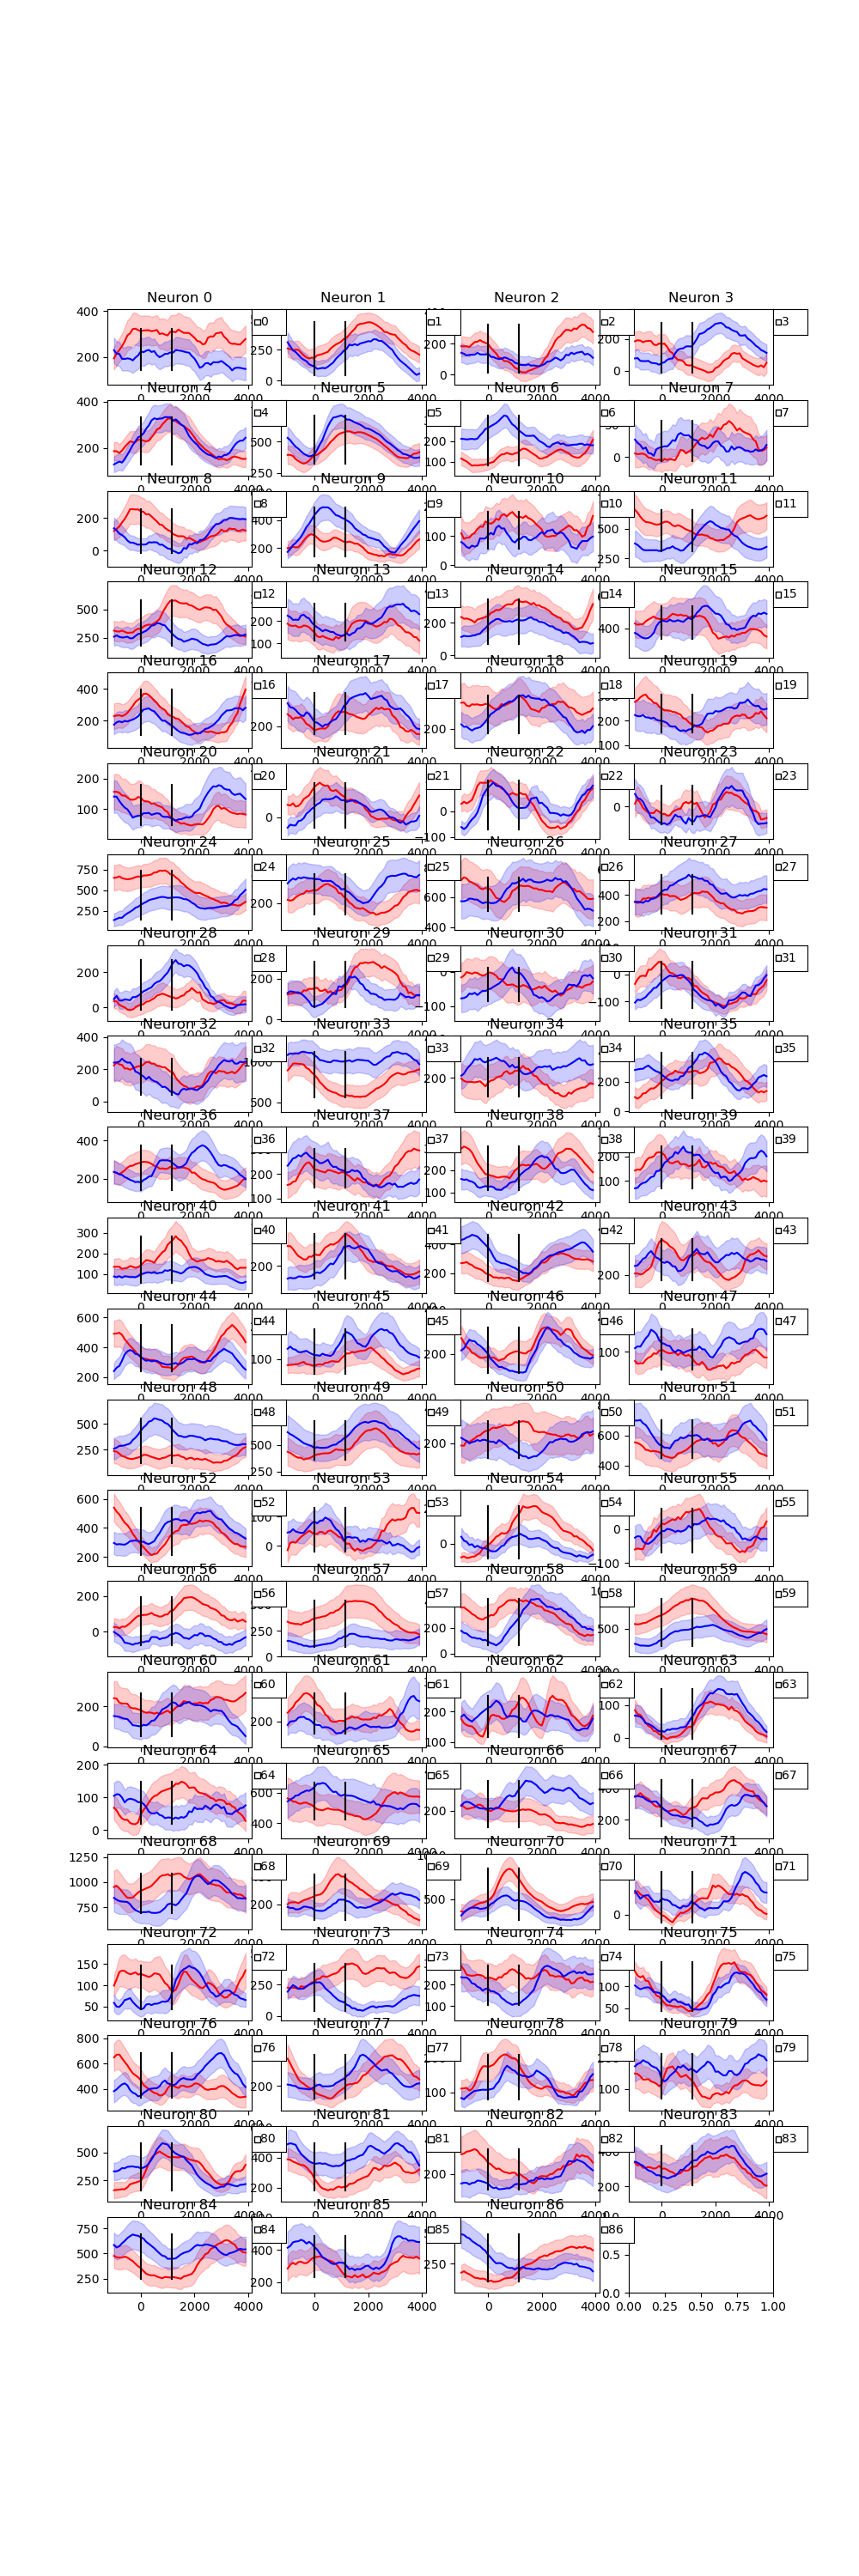

In [13]:

%matplotlib widget
# Example DataFrames
# neuron_traces = pd.DataFrame(...)  # Your neuron traces data
# data = pd.DataFrame(...)  # Your laser event data

# Sample neuron to plot
#neuron_id = 2  # Adjust this based on the neuron you want to plot

# Time conversion
sampling_rate = 10  # Hz
pre_event_points = 1000 // (1000 / sampling_rate)  # 500 ms before
post_event_points = 4000 // (1000 / sampling_rate)  # 3000 ms after

# Function to extract data around laser event
def extract_data(side, n_id):
    times = data[data['side'] == side]['tone_ts']
    indices = (times * sampling_rate / 1000).astype(int)
    traces = []
    for idx in indices:
        start = int(idx - pre_event_points)
        end = int( idx + post_event_points)
        if start > 500 & end < neuron_traces.shape[1]-1:
            trace = neuron_traces[n_id, start:end]
            if trace.shape[0] == pre_event_points + post_event_points:
                traces.append(trace)
    return np.array(traces)


def plot_neu(neuron_id, ax_n, cols):
    for i in np.arange(cols):
        if neuron_id+i>=neuron_traces.shape[0]:
            break
        # Extract data for each laser type
        traces_1 = extract_data(1, neuron_id+i)

        traces_0 = extract_data(-1, neuron_id+i)
        # Mean and std
        mean_trace_1 = np.mean(traces_1, axis=0)
        std_trace_1 = sem(traces_1, axis=0)

        mean_trace_0 = np.mean(traces_0, axis=0)
        std_trace_0 = sem(traces_0, axis=0)
        # Laser = 1
        axs[ax_n,i].plot(time_points, mean_trace_1, color='r', label='Mean')
        axs[ax_n,i].fill_between(time_points, mean_trace_1 - std_trace_1, mean_trace_1 + std_trace_1, color='r', alpha=0.2)

        # Laser = 0
        axs[ax_n,i].plot(time_points, mean_trace_0, color='b', label='Mean')
        axs[ax_n,i].fill_between(time_points, mean_trace_0 - std_trace_0, mean_trace_0 + std_trace_0, color='b', alpha=0.2)
        axs[ax_n,i].set_title('Neuron '+ str(neuron_id+i))

        # Lines at start tone, start response
        min_v = np.amin([np.amin(mean_trace_1), np.amin(mean_trace_0)])
        max_v = np.amax([np.amax(mean_trace_1), np.amax(mean_trace_0)])
        maxes = [np.amin(mean_trace_1), np.amax(mean_trace_1)]
        axs[ax_n,i].plot([0,0], [min_v, max_v], color='k', label='tone')
        axs[ax_n,i].plot([1150,1150], [min_v, max_v], color='k', label='RESPONSE')

        # Create a small axis for the checkbox next to each subplot
        bbox = axs[ax_n, i].get_position()

        ax_check = fig.add_axes([bbox.xmax, bbox.ymax-0.01, 0.04, 0.01])
        
        checkbox = CheckButtons(ax_check, [str(neuron_id+i)], [False])
        checkbox_axes.append(checkbox)



# Time points for x-axis
time_points = np.arange(-pre_event_points, post_event_points) * (1000 / sampling_rate)





# Plotting
cols = 4
nneu = neuron_traces.shape[0]
rows = math.ceil(nneu/cols)
fig, axs = plt.subplots(rows, cols, figsize=(10, 30))

checkbox_axes = []

neu_indx = np.arange(0,nneu,cols)
for n in np.arange(len(neu_indx)):
    plot_neu(neu_indx[n], n, cols)
    


plt.show()

relevant_neu = []

def check_handler(label):
    neuron_id = int(label)
    if neuron_id in relevant_neu:
        relevant_neu.remove(neuron_id)
    else:
        relevant_neu.append(neuron_id)

# Attach the handler to each checkbox
for check in checkbox_axes:
    check.on_clicked(check_handler)

Here, let's start with a simple left vs right trial differentiation. We need to select for a given neuron, let's consider first 2 s after the tone start. Let's look at the aread under the curve for that, later we do thia thing for the peak amplitude
Do a simple t test and verify with permutation test

In [18]:
data['frame'] = (data['tone_ts']* sampling_rate / 1000).astype(int)

In [22]:

data['prev_same'] = 

,missed,laser,side,tone_ts,choice,free,frame,auc_2s_after_tone
0,0,0,-1,2163,-1,0,21,-5289.161113
1,0,0,1,5941,-1,0,59,173.173986
2,1,0,1,11098,0,0,110,10264.217458
3,1,0,-1,15557,0,0,155,-6425.645162
4,1,2,1,20004,0,0,200,-10356.172320
...,...,...,...,...,...,...,...,...
245,0,1,1,1007431,1,0,10074,-4712.799242
246,0,0,-1,1011224,-1,0,10112,-3837.746551
247,0,2,-1,1015223,-1,0,10152,1275.186472
248,0,2,1,1019026,1,0,10190,-2543.988727


In [67]:

for n in np.arange(85):
    trace  = neuron_traces[n][:]
    data['auc_2s_after_tone'] = [sum(trace[f+11:f+21]) for f in data['frame'] ]
    auc_l = data[data['rand']==True]['auc_2s_after_tone']
    auc_r = data[data['rand']== False]['auc_2s_after_tone']
    p_value = permutation_test(auc_l, auc_r, 10000)  # Assuming unequal variances
    if p_value < 0.01:
        print(f"==PERFECT permutation P-value for neuron {n}: {p_value}")
    elif p_value < 0.05:
        print(f"Permutation P-value for neuron {n}: {p_value}")
    elif p_value < 0.1:
        print(f"Lousy permutation P-value for neuron {n}: {p_value}")


Permutation P-value for neuron 14: 0.0179
Lousy permutation P-value for neuron 23: 0.0524
Permutation P-value for neuron 26: 0.0377
Lousy permutation P-value for neuron 28: 0.05
Permutation P-value for neuron 29: 0.0445
Lousy permutation P-value for neuron 32: 0.06
Lousy permutation P-value for neuron 38: 0.089
Lousy permutation P-value for neuron 42: 0.0856
Permutation P-value for neuron 48: 0.0444
Permutation P-value for neuron 64: 0.0121
Lousy permutation P-value for neuron 74: 0.0938
Lousy permutation P-value for neuron 76: 0.0648
Lousy permutation P-value for neuron 81: 0.0544
==PERFECT permutation P-value for neuron 84: 0.0007


In [69]:

for n in np.arange(85):
    trace  = neuron_traces[n][:]
    data['auc_2s_after_tone'] = [sum(trace[f+11:f+21]) for f in data['frame'] ]
    auc_l = data[data['choice']==-1]['auc_2s_after_tone']
    auc_r = data[data['choice']== 1]['auc_2s_after_tone']
    p_value = permutation_test(auc_l, auc_r, 10000)  # Assuming unequal variances
    if p_value < 0.015:
        print(f"==PERFECT permutation P-value for neuron {n}: {p_value}")
    elif p_value < 0.05:
        print(f"Permutation P-value for neuron {n}: {p_value}")
    elif p_value < 0.1:
        print(f"Lousy permutation P-value for neuron {n}: {p_value}")


==PERFECT permutation P-value for neuron 3: 0.0086
Permutation P-value for neuron 19: 0.0481
==PERFECT permutation P-value for neuron 24: 0.012
Permutation P-value for neuron 32: 0.0493
Lousy permutation P-value for neuron 38: 0.0698
Lousy permutation P-value for neuron 45: 0.0936
Permutation P-value for neuron 56: 0.0379
==PERFECT permutation P-value for neuron 65: 0.0058
==PERFECT permutation P-value for neuron 73: 0.0118
Lousy permutation P-value for neuron 79: 0.0687


In [70]:

for n in np.arange(85):
    trace  = neuron_traces[n][:]
    data['auc_2s_after_tone'] = [sum(trace[f+11:f+21]) for f in data['frame'] ]
    auc_l = data[data['prev_same']==True]['auc_2s_after_tone']
    auc_r = data[data['prev_same']==False]['auc_2s_after_tone']
    p_value = permutation_test(auc_l, auc_r, 10000)  # Assuming unequal variances
    if p_value < 0.015:
        print(f"==PERFECT permutation P-value for neuron {n}: {p_value}")
    elif p_value < 0.05:
        print(f"Permutation P-value for neuron {n}: {p_value}")
    elif p_value < 0.1:
        print(f"Lousy permutation P-value for neuron {n}: {p_value}")


Permutation P-value for neuron 29: 0.0361
Permutation P-value for neuron 31: 0.043
Permutation P-value for neuron 36: 0.0367
Lousy permutation P-value for neuron 50: 0.0624
Permutation P-value for neuron 52: 0.0437
Lousy permutation P-value for neuron 72: 0.0936


In [73]:

for n in np.arange(85):
    trace  = neuron_traces[n][:]
    data['auc_2s_after_tone'] = [sum(trace[f:f+15]) for f in data['frame'] ]
    auc_l = data[(data['prev_same']==True) & (data['choice']==-1)]['auc_2s_after_tone']
    auc_r = data[(data['prev_same']==False) & (data['choice']==-1)]['auc_2s_after_tone']
    p_value = permutation_test(auc_l, auc_r, 10000)  # Assuming unequal variances
    if p_value < 0.015:
        print(f"==PERFECT permutation P-value for neuron {n}: {p_value}")
    elif p_value < 0.05:
        print(f"Permutation P-value for neuron {n}: {p_value}")
    elif p_value < 0.1:
        print(f"Lousy permutation P-value for neuron {n}: {p_value}")


==PERFECT permutation P-value for neuron 4: 0.0078
Lousy permutation P-value for neuron 20: 0.0852
Lousy permutation P-value for neuron 27: 0.0782
==PERFECT permutation P-value for neuron 44: 0.004
Lousy permutation P-value for neuron 52: 0.07
Permutation P-value for neuron 75: 0.0216


In [78]:

for n in np.arange(85):
    trace  = neuron_traces[n][:]
    data['auc_2s_after_tone'] = [sum(trace[f:f+12]) for f in data['frame'] ]
    auc_l = data[(data['prev_same']==True) & (data['choice']==1)]['auc_2s_after_tone']
    auc_r = data[(data['prev_same']==False) & (data['choice']==1)]['auc_2s_after_tone']
    p_value = permutation_test(auc_l, auc_r, 10000)  # Assuming unequal variances
    if p_value < 0.015:
        print(f"==PERFECT permutation P-value for neuron {n}: {p_value}")
    elif p_value < 0.05:
        print(f"Permutation P-value for neuron {n}: {p_value}")
    elif p_value < 0.1:
        print(f"Lousy permutation P-value for neuron {n}: {p_value}")


Permutation P-value for neuron 0: 0.0217
Permutation P-value for neuron 11: 0.048
Lousy permutation P-value for neuron 31: 0.0751
Lousy permutation P-value for neuron 40: 0.0899
Permutation P-value for neuron 61: 0.0162


In [ ]:

for n in np.arange(85):
    trace  = neuron_traces[n][:]
    data['auc_2s_after_tone'] = [sum(trace[f+11:f+21]) for f in data['frame'] ]
    auc_l = data[(data['prev_same']==True) & (data['choice']==-1)]['auc_2s_after_tone']
    auc_r = data[(data['prev_same']==False) & (data['choice']==-1)]['auc_2s_after_tone']
    p_value = permutation_test(auc_l, auc_r, 10000)  # Assuming unequal variances
    if p_value < 0.015:
        print(f"==PERFECT permutation P-value for neuron {n}: {p_value}")
    elif p_value < 0.05:
        print(f"Permutation P-value for neuron {n}: {p_value}")
    elif p_value < 0.1:
        print(f"Lousy permutation P-value for neuron {n}: {p_value}")


In [109]:

for n in np.arange(85):
    trace  = neuron_traces[n][:]
    data['auc_2s_after_tone'] = [sum(trace[f:f+21]) for f in data['frame'] ]
    auc_l = data[(data['prev_same']==True) & (data['choice']==-1) & (data['missed']==0) & (data['correct']==True)]['auc_2s_after_tone']
    auc_r = data[(data['prev_same']==False) & (data['choice']==-1) & (data['missed']==0) & (data['correct']==True)]['auc_2s_after_tone']
    p_value = permutation_test(auc_l, auc_r, 10000)  # Assuming unequal variances
    if p_value < 0.015:
        print(f"==PERFECT permutation P-value for neuron {n}: {p_value}")
    elif p_value < 0.05:
        print(f"Permutation P-value for neuron {n}: {p_value}")
    elif p_value < 0.1:
        print(f"Lousy permutation P-value for neuron {n}: {p_value}")


Lousy permutation P-value for neuron 2: 0.0776
==PERFECT permutation P-value for neuron 4: 0.0129
Permutation P-value for neuron 18: 0.0487
Permutation P-value for neuron 21: 0.0193
Lousy permutation P-value for neuron 27: 0.0505
Lousy permutation P-value for neuron 36: 0.0586
==PERFECT permutation P-value for neuron 44: 0.0066
Lousy permutation P-value for neuron 72: 0.0941
Lousy permutation P-value for neuron 75: 0.0785


In [104]:

for n in np.arange(85):
    trace  = neuron_traces[n][:]
    data['auc_2s_after_tone'] = [sum(trace[f:f+11]) for f in data['frame'] ]
    auc_l = data[(data['missed']==0) ]['auc_2s_after_tone']
    auc_r = data[(data['missed']==1) ]['auc_2s_after_tone']
    p_value = permutation_test(auc_l, auc_r, 10000)  # Assuming unequal variances
    if p_value < 0.015:
        print(f"==PERFECT permutation P-value for neuron {n}: {p_value}")
    elif p_value < 0.05:
        print(f"Permutation P-value for neuron {n}: {p_value}")
    elif p_value < 0.1:
        print(f"Lousy permutation P-value for neuron {n}: {p_value}")


Lousy permutation P-value for neuron 10: 0.0859
Permutation P-value for neuron 18: 0.035
Permutation P-value for neuron 47: 0.0429
Lousy permutation P-value for neuron 75: 0.0868


In [60]:
import random
# Generate a list of random True/False values
random_bool_list = [random.choice([True, False]) for _ in range(250)]
data['rand'] = random_bool_list
data

,missed,laser,side,tone_ts,choice,free,frame,auc_2s_after_tone,prev_same,rand
0,0,0,-1,2163,-1,0,21,2132.331657,False,True
1,0,0,1,5941,-1,0,59,3810.929455,False,True
2,1,0,1,11098,0,0,110,3493.134552,True,False
3,1,0,-1,15557,0,0,155,5050.990902,False,False
4,1,2,1,20004,0,0,200,1786.745740,False,True
...,...,...,...,...,...,...,...,...,...,...
245,0,1,1,1007431,1,0,10074,481.909211,True,True
246,0,0,-1,1011224,-1,0,10112,174.157277,False,False
247,0,2,-1,1015223,-1,0,10152,469.113680,True,False
248,0,2,1,1019026,1,0,10190,630.678245,False,True


In [79]:
sum(data['missed'])

18

In [40]:


def permutation_test(data1, data2, n_permutations=10000):
    """
    Perform a permutation test on two datasets.
    
    Parameters:
    - data1, data2: Arrays containing the data for the two groups.
    - n_permutations: Number of permutations to perform.
    
    Returns:
    - p-value: The proportion of permuted statistics more extreme than the observed.
    """
    # Calculate the observed difference in means
    observed_diff = np.mean(data1) - np.mean(data2)
    
    # Concatenate the datasets
    combined_data = np.concatenate([data1, data2])
    
    # Initialize a counter for permutations where the permuted difference is more extreme than observed
    count_extreme = 0
    
    # Perform permutations
    for _ in range(n_permutations):
        # Shuffle the combined data
        np.random.shuffle(combined_data)
        
        # Split the permuted dataset
        permuted_data1 = combined_data[:len(data1)]
        permuted_data2 = combined_data[len(data1):]
        
        # Calculate the difference in means for the permuted datasets
        permuted_diff = np.mean(permuted_data1) - np.mean(permuted_data2)
        
        # Check if the permuted difference is as extreme as the observed difference
        if abs(permuted_diff) >= abs(observed_diff):
            count_extreme += 1
    
    # Calculate the p-value
    p_value = count_extreme / n_permutations
    
    return p_value


In [14]:
relevant_neu = []

# Attach the handler to each checkbox
n = 0
for check in checkbox_axes:
    if check.get_status()==[True]:
        relevant_neu.append(n)
    n+=1


In [15]:
len(relevant_neu)

6

# For each side, select prev_same and prev_diff

In [81]:
#data['prev_same'] = 
prev_same=[data['side'][n]==data['side'][n-1] for n in np.arange(1,data.shape[0])]

start=[None]
start.extend(prev_same)
prev_same = start
data['prev_same'] = prev_same
data.head()

,missed,laser,side,tone_ts,choice,free,frame,auc_2s_after_tone,prev_same,rand
0,0,0,-1,2163,-1,0,21,20493.368010,None,True
1,0,0,1,5941,-1,0,59,33524.511134,False,True
2,1,0,1,11098,0,0,110,-3154.343183,True,False
3,1,0,-1,15557,0,0,155,11079.961588,False,False
4,1,2,1,20004,0,0,200,-1572.319758,False,True


In [83]:
correct = [data['side'][n]==data['choice'][n] for n in np.arange(data.shape[0])]
data['correct'] = correct
data

,missed,laser,side,tone_ts,choice,free,frame,auc_2s_after_tone,prev_same,rand,correct
0,0,0,-1,2163,-1,0,21,20493.368010,None,True,True
1,0,0,1,5941,-1,0,59,33524.511134,False,True,False
2,1,0,1,11098,0,0,110,-3154.343183,True,False,False
3,1,0,-1,15557,0,0,155,11079.961588,False,False,False
4,1,2,1,20004,0,0,200,-1572.319758,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
245,0,1,1,1007431,1,0,10074,1923.053105,True,True,True
246,0,0,-1,1011224,-1,0,10112,-1017.801207,False,False,True
247,0,2,-1,1015223,-1,0,10152,1857.035531,True,False,True
248,0,2,1,1019026,1,0,10190,-867.913308,False,True,True


In [90]:
correct = []
for n in np.arange(data.shape[0]):
    if data['side'][n]==data['choice'][n]:
        correct.extend([True])
    elif data['side'][n]==-data['choice'][n]:
        correct.extend([False])
    elif data['choice'][n]==0:
        correct.extend([None])
data['correct'] = correct
data

,missed,laser,side,tone_ts,choice,free,frame,auc_2s_after_tone,prev_same,rand,correct
0,0,0,-1,2163,-1,0,21,20493.368010,None,True,True
1,0,0,1,5941,-1,0,59,33524.511134,False,True,False
2,1,0,1,11098,0,0,110,-3154.343183,True,False,None
3,1,0,-1,15557,0,0,155,11079.961588,False,False,None
4,1,2,1,20004,0,0,200,-1572.319758,False,True,None
...,...,...,...,...,...,...,...,...,...,...,...
245,0,1,1,1007431,1,0,10074,1923.053105,True,True,True
246,0,0,-1,1011224,-1,0,10112,-1017.801207,False,False,True
247,0,2,-1,1015223,-1,0,10152,1857.035531,True,False,True
248,0,2,1,1019026,1,0,10190,-867.913308,False,True,True


In [97]:
sum([1 for n in np.arange(data.shape[0]) if ( (data['correct'][n]==False) & (data['side'][n]==-1))])

13

# Plot prev same and prev diff for the left side and right sides

In [ ]:


# Example DataFrames
# neuron_traces = pd.DataFrame(...)  # Your neuron traces data
# data = pd.DataFrame(...)  # Your laser event data

# Sample neuron to plot
#neuron_id = 2  # Adjust this based on the neuron you want to plot

# Time conversion
sampling_rate = 10  # Hz
pre_event_points = 1000 // (1000 / sampling_rate)  # 500 ms before
post_event_points = 4000 // (1000 / sampling_rate)  # 3000 ms after

# Function to extract data around laser event
def extract_data(side, prev_same, n_id):
    times = data[(data['side'] == side) & (data['prev_same'] == prev_same)]['tone_ts']
    indices = (times * sampling_rate / 1000).astype(int)
    traces = []
    for idx in indices:
        start = int(idx - pre_event_points)
        end = int( idx + post_event_points)
        if start > 500 & end < neuron_traces.shape[1]-1:
            trace = neuron_traces[n_id, start:end]
            if trace.shape[0] == pre_event_points + post_event_points:
                traces.append(trace)
    return np.array(traces)


def plot_neu(neuron_id, ax_n):
    # Left side
    side = 1
    traces_L_same = extract_data(side, True, neuron_id)
    traces_L_diff = extract_data(side, False, neuron_id)
    # Mean and std
    mean_trace_L_same = np.mean(traces_L_same, axis=0)
    std_trace_L_same = sem(traces_L_same, axis=0)
    mean_trace_L_diff = np.mean(traces_L_diff, axis=0)
    std_trace_L_diff = sem(traces_L_diff, axis=0)

    # Plot 
    axs[ax_n,0].plot(time_points, mean_trace_L_same, color='b', label='Same')
    axs[ax_n,0].fill_between(time_points, mean_trace_L_same - std_trace_L_same, mean_trace_L_same + std_trace_L_same, color='b', alpha=0.2)
    axs[ax_n,0].plot(time_points, mean_trace_L_diff, color='r', label='Diff')
    axs[ax_n,0].fill_between(time_points, mean_trace_L_diff - std_trace_L_diff, mean_trace_L_diff + std_trace_L_diff, color='r', alpha=0.2)
    axs[ax_n,0].set_title('Neuron '+ str(neuron_id) + ', left')

        # Lines at start tone, start response
    min_v = np.amin([np.amin(mean_trace_L_same), np.amin(mean_trace_L_diff)])
    max_v = np.amax([np.amax(mean_trace_L_same), np.amax(mean_trace_L_diff)])
    axs[ax_n,0].plot([0,0], [min_v, max_v], color='k', label='tone')
    axs[ax_n,0].plot([1150,1150], [min_v, max_v], color='k', label='RESPONSE')
    
    # Right side
    side = -1
    traces_L_same = extract_data(side, True, neuron_id)
    traces_L_diff = extract_data(side, False, neuron_id)
    # Mean and std
    mean_trace_L_same = np.mean(traces_L_same, axis=0)
    std_trace_L_same = sem(traces_L_same, axis=0)
    mean_trace_L_diff = np.mean(traces_L_diff, axis=0)
    std_trace_L_diff = sem(traces_L_diff, axis=0)

    # Plot 
    axs[ax_n,1].plot(time_points, mean_trace_L_same, color='b', label='Same')
    axs[ax_n,1].fill_between(time_points, mean_trace_L_same - std_trace_L_same, mean_trace_L_same + std_trace_L_same, color='b', alpha=0.2)
    axs[ax_n,1].plot(time_points, mean_trace_L_diff, color='r', label='Diff')
    axs[ax_n,1].fill_between(time_points, mean_trace_L_diff - std_trace_L_diff, mean_trace_L_diff + std_trace_L_diff, color='r', alpha=0.2)
    axs[ax_n,1].set_title('Neuron '+ str(neuron_id) + ', right')
            # Lines at start tone, start response
    min_v = np.amin([np.amin(mean_trace_L_same), np.amin(mean_trace_L_diff)])
    max_v = np.amax([np.amax(mean_trace_L_same), np.amax(mean_trace_L_diff)])
    axs[ax_n,1].plot([0,0], [min_v, max_v], color='k', label='tone')
    axs[ax_n,1].plot([1150,1150], [min_v, max_v], color='k', label='RESPONSE')



# Time points for x-axis
time_points = np.arange(-pre_event_points, post_event_points) * (1000 / sampling_rate)

# Plotting

fig, axs = plt.subplots(len(relevant_neu), 2, figsize=(10, 70))

for n in np.arange(len(relevant_neu)):
    plot_neu(relevant_neu[n], n)

plt.show()

# Now, same but without errors

In [ ]:


# Example DataFrames
# neuron_traces = pd.DataFrame(...)  # Your neuron traces data
# data = pd.DataFrame(...)  # Your laser event data

# Sample neuron to plot
#neuron_id = 2  # Adjust this based on the neuron you want to plot

# Time conversion
sampling_rate = 10  # Hz
pre_event_points = 1000 // (1000 / sampling_rate)  # 500 ms before
post_event_points = 4000 // (1000 / sampling_rate)  # 3000 ms after

# Function to extract data around laser event
def extract_data(side, prev_same, n_id):
    times = data[(data['side'] == side) & (data['prev_same'] == prev_same) & (data['choice'] == side)]['tone_ts']
    indices = (times * sampling_rate / 1000).astype(int)
    traces = []
    for idx in indices:
        start = int(idx - pre_event_points)
        end = int( idx + post_event_points)
        if start > 500 & end < neuron_traces.shape[1]-1:
            trace = neuron_traces[n_id, start:end]
            if trace.shape[0] == pre_event_points + post_event_points:
                traces.append(trace)
    return np.array(traces)


def plot_neu(neuron_id, ax_n):
    # Left side
    side = 1
    traces_L_same = extract_data(side, True, neuron_id)
    traces_L_diff = extract_data(side, False, neuron_id)
    # Mean and std
    mean_trace_L_same = np.mean(traces_L_same, axis=0)
    std_trace_L_same = sem(traces_L_same, axis=0)
    mean_trace_L_diff = np.mean(traces_L_diff, axis=0)
    std_trace_L_diff = sem(traces_L_diff, axis=0)

    # Plot 
    axs[ax_n,0].plot(time_points, mean_trace_L_same, color='b', label='Same')
    axs[ax_n,0].fill_between(time_points, mean_trace_L_same - std_trace_L_same, mean_trace_L_same + std_trace_L_same, color='b', alpha=0.2)
    axs[ax_n,0].plot(time_points, mean_trace_L_diff, color='r', label='Diff')
    axs[ax_n,0].fill_between(time_points, mean_trace_L_diff - std_trace_L_diff, mean_trace_L_diff + std_trace_L_diff, color='r', alpha=0.2)
    axs[ax_n,0].set_title('Neuron '+ str(neuron_id) + ', left')

        # Lines at start tone, start response
    min_v = np.amin([np.amin(mean_trace_L_same), np.amin(mean_trace_L_diff)])
    max_v = np.amax([np.amax(mean_trace_L_same), np.amax(mean_trace_L_diff)])
    axs[ax_n,0].plot([0,0], [min_v, max_v], color='k', label='tone')
    axs[ax_n,0].plot([1150,1150], [min_v, max_v], color='k', label='RESPONSE')
    
    # Right side
    side = -1
    traces_L_same = extract_data(side, True, neuron_id)
    traces_L_diff = extract_data(side, False, neuron_id)
    # Mean and std
    mean_trace_L_same = np.mean(traces_L_same, axis=0)
    std_trace_L_same = sem(traces_L_same, axis=0)
    mean_trace_L_diff = np.mean(traces_L_diff, axis=0)
    std_trace_L_diff = sem(traces_L_diff, axis=0)

    # Plot 
    axs[ax_n,1].plot(time_points, mean_trace_L_same, color='b', label='Same')
    axs[ax_n,1].fill_between(time_points, mean_trace_L_same - std_trace_L_same, mean_trace_L_same + std_trace_L_same, color='b', alpha=0.2)
    axs[ax_n,1].plot(time_points, mean_trace_L_diff, color='r', label='Diff')
    axs[ax_n,1].fill_between(time_points, mean_trace_L_diff - std_trace_L_diff, mean_trace_L_diff + std_trace_L_diff, color='r', alpha=0.2)
    axs[ax_n,1].set_title('Neuron '+ str(neuron_id) + ', right')
            # Lines at start tone, start response
    min_v = np.amin([np.amin(mean_trace_L_same), np.amin(mean_trace_L_diff)])
    max_v = np.amax([np.amax(mean_trace_L_same), np.amax(mean_trace_L_diff)])
    axs[ax_n,1].plot([0,0], [min_v, max_v], color='k', label='tone')
    axs[ax_n,1].plot([1150,1150], [min_v, max_v], color='k', label='RESPONSE')



# Time points for x-axis
time_points = np.arange(-pre_event_points, post_event_points) * (1000 / sampling_rate)

# Plotting

fig, axs = plt.subplots(len(relevant_neu), 2, figsize=(10, 70))

for n in np.arange(len(relevant_neu)):
    plot_neu(relevant_neu[n], n)

plt.show()

# Now, no errors next to errors 

In [ ]:
# Function to extract data around laser event
def extract_data_side_prev_correct(side, prev_same, correct, n_id):
    if correct:
        choice = side
    else:
        choice = - side
    times = data[(data['side'] == side) & (data['prev_same'] == prev_same) & (data['choice'] == choice)]['tone_ts']
    indices = (times * sampling_rate / 1000).astype(int)
    traces = []
    for idx in indices:
        start = int(idx - pre_event_points)
        end = int( idx + post_event_points)
        if start > 500 & end < neuron_traces.shape[1]-1:
            trace = neuron_traces[n_id, start:end]
            if trace.shape[0] == pre_event_points + post_event_points:
                traces.append(trace)
    return np.array(traces)

In [ ]:
# Time conversion
sampling_rate = 10  # Hz
pre_event_points = 6000 // (1000 / sampling_rate)  # 500 ms before
post_event_points = 5000 // (1000 / sampling_rate)  # 3000 ms after

def plot_neu(neuron_id, ax_n):
    sides = [1,1,-1,-1]
    correctnesses = [True, False, True, False]
    titles = ['left correct','left incorrect','right correct','right incorrect']

    for i in [0,1,2,3]:
        side = sides[i]
        correctness = correctnesses[i]
        traces_same = extract_data_side_prev_correct(side, True, correctness, neuron_id)
        traces_diff = extract_data_side_prev_correct(side, False, correctness, neuron_id)
    
        # Mean and std
        mean_trace_same = np.mean(traces_same, axis=0)
        std_trace_same = sem(traces_same, axis=0)
        mean_trace_diff = np.mean(traces_diff, axis=0)
        std_trace_diff = sem(traces_diff, axis=0)

    # Plot 
        axs[ax_n,i].plot(time_points, mean_trace_same, color='b', label='Same')
        axs[ax_n,i].fill_between(time_points, mean_trace_same - std_trace_same, mean_trace_same + std_trace_same, color='b', alpha=0.2)
        axs[ax_n,i].plot(time_points, mean_trace_diff, color='r', label='Diff')
        axs[ax_n,i].fill_between(time_points, mean_trace_diff - std_trace_diff, mean_trace_diff + std_trace_diff, color='r', alpha=0.2)
        axs[ax_n,i].set_title('Neuron '+ str(neuron_id) + ', ' + titles[i])

        # Lines at start tone, start response
        min_v = np.amin([np.amin(mean_trace_same), np.amin(mean_trace_diff)])
        max_v = np.amax([np.amax(mean_trace_same), np.amax(mean_trace_diff)])
        axs[ax_n,i].plot([0,0], [min_v, max_v], color='k', label='tone')
        axs[ax_n,i].plot([1150,1150], [min_v, max_v], color='k', label='RESPONSE')


# Time points for x-axis
time_points = np.arange(-pre_event_points, post_event_points) * (1000 / sampling_rate)

# Plotting

fig, axs = plt.subplots(len(relevant_neu), 4, figsize=(10, 70))

for n in np.arange(len(relevant_neu)):
    plot_neu(relevant_neu[n], n)

plt.show()

In [ ]:
# Time conversion
sampling_rate = 10  # Hz
pre_event_points = 500 // (1000 / sampling_rate)  # 500 ms before
post_event_points = 3000 // (1000 / sampling_rate)  # 3000 ms after

def plot_neu(neuron_id, ax_n):
    sides = [1,1,-1,-1]
    correctnesses = [True, False, True, False]
    titles = ['left correct','left incorrect','right correct','right incorrect']

    for i in [0,1,2,3]:
        side = sides[i]
        correctness = correctnesses[i]
        traces_same = extract_data_side_prev_correct(side, True, correctness, neuron_id)
        traces_diff = extract_data_side_prev_correct(side, False, correctness, neuron_id)

    # Plot
        for trace in traces_same:
            axs[ax_n,i].plot(time_points, trace, color='b', label='Same', alpha=0.3)
        for trace in traces_diff:
            axs[ax_n,i].plot(time_points, trace, color='r', label='Same', alpha=0.3)
            

        axs[ax_n,i].set_title('Neuron '+ str(neuron_id) + ', ' + titles[i])

        # Lines at start tone, start response
        min_v = np.amin([np.amin(traces_same), np.amin(traces_diff)])
        max_v = np.amax([np.amax(traces_same), np.amax(traces_diff)])
        axs[ax_n,i].plot([0,0], [min_v, max_v], color='k', label='tone')
        axs[ax_n,i].plot([1150,1150], [min_v, max_v], color='k', label='RESPONSE')


# Time points for x-axis
time_points = np.arange(-pre_event_points, post_event_points) * (1000 / sampling_rate)

# Plotting

fig, axs = plt.subplots(len(relevant_neu), 4, figsize=(10, 70))

for n in np.arange(len(relevant_neu)):
    plot_neu(relevant_neu[n], n)

plt.show()

In [ ]:
# Only errors

In [ ]:


# Example DataFrames
# neuron_traces = pd.DataFrame(...)  # Your neuron traces data
# data = pd.DataFrame(...)  # Your laser event data

# Sample neuron to plot
#neuron_id = 2  # Adjust this based on the neuron you want to plot

# Time conversion
sampling_rate = 10  # Hz
pre_event_points = 1000 // (1000 / sampling_rate)  # 500 ms before
post_event_points = 4000 // (1000 / sampling_rate)  # 3000 ms after

# Function to extract data around laser event
def extract_data(side, prev_same, n_id):
    times = data[(data['side'] == side) & (data['prev_same'] == prev_same) & (data['choice_made'] == -side)]['tone_ts']
    indices = (times * sampling_rate / 1000).astype(int)
    traces = []
    for idx in indices:
        start = int(idx - pre_event_points)
        end = int( idx + post_event_points)
        if start > 500 & end < neuron_traces.shape[1]-1:
            trace = neuron_traces[n_id, start:end]
            if trace.shape[0] == pre_event_points + post_event_points:
                traces.append(trace)
    return np.array(traces)


def plot_neu(neuron_id, ax_n):
    # Left side
    side = 1
    traces_L_same = extract_data(side, True, neuron_id)
    traces_L_diff = extract_data(side, False, neuron_id)
    # Mean and std
    mean_trace_L_same = np.mean(traces_L_same, axis=0)
    std_trace_L_same = sem(traces_L_same, axis=0)
    mean_trace_L_diff = np.mean(traces_L_diff, axis=0)
    std_trace_L_diff = sem(traces_L_diff, axis=0)

    # Plot 
    axs[ax_n,0].plot(time_points, mean_trace_L_same, color='b', label='Same')
    axs[ax_n,0].fill_between(time_points, mean_trace_L_same - std_trace_L_same, mean_trace_L_same + std_trace_L_same, color='b', alpha=0.2)
    axs[ax_n,0].plot(time_points, mean_trace_L_diff, color='r', label='Diff')
    axs[ax_n,0].fill_between(time_points, mean_trace_L_diff - std_trace_L_diff, mean_trace_L_diff + std_trace_L_diff, color='r', alpha=0.2)
    axs[ax_n,0].set_title('Neuron '+ str(neuron_id) + ', left')

        # Lines at start tone, start response
    min_v = np.amin([np.amin(mean_trace_L_same), np.amin(mean_trace_L_diff)])
    max_v = np.amax([np.amax(mean_trace_L_same), np.amax(mean_trace_L_diff)])
    axs[ax_n,0].plot([0,0], [min_v, max_v], color='k', label='tone')
    axs[ax_n,0].plot([1150,1150], [min_v, max_v], color='k', label='RESPONSE')
    
    # Right side
    side = -1
    traces_L_same = extract_data(side, True, neuron_id)
    traces_L_diff = extract_data(side, False, neuron_id)
    # Mean and std
    mean_trace_L_same = np.mean(traces_L_same, axis=0)
    std_trace_L_same = sem(traces_L_same, axis=0)
    mean_trace_L_diff = np.mean(traces_L_diff, axis=0)
    std_trace_L_diff = sem(traces_L_diff, axis=0)

    # Plot 
    axs[ax_n,1].plot(time_points, mean_trace_L_same, color='b', label='Same')
    axs[ax_n,1].fill_between(time_points, mean_trace_L_same - std_trace_L_same, mean_trace_L_same + std_trace_L_same, color='b', alpha=0.2)
    axs[ax_n,1].plot(time_points, mean_trace_L_diff, color='r', label='Diff')
    axs[ax_n,1].fill_between(time_points, mean_trace_L_diff - std_trace_L_diff, mean_trace_L_diff + std_trace_L_diff, color='r', alpha=0.2)
    axs[ax_n,1].set_title('Neuron '+ str(neuron_id) + ', right')
            # Lines at start tone, start response
    min_v = np.amin([np.amin(mean_trace_L_same), np.amin(mean_trace_L_diff)])
    max_v = np.amax([np.amax(mean_trace_L_same), np.amax(mean_trace_L_diff)])
    axs[ax_n,1].plot([0,0], [min_v, max_v], color='k', label='tone')
    axs[ax_n,1].plot([1150,1150], [min_v, max_v], color='k', label='RESPONSE')



# Time points for x-axis
time_points = np.arange(-pre_event_points, post_event_points) * (1000 / sampling_rate)

# Plotting

fig, axs = plt.subplots(len(relevant_neu), 2, figsize=(10, 70))

for n in np.arange(len(relevant_neu)):
    plot_neu(relevant_neu[n], n)

plt.show()

In [ ]:
data[(data['choice']==-1) & (data['side']==1)].shape

correct 
left: 78; right: 104
error
left: 13; right: 35



In [ ]:
relevant_neu
# Save the numbers of the good components
relevant_neu_df = pd.DataFrame(relevant_neu, columns=['relevant_neu'])
relevant_neu_df.to_csv(path + 'relevant_neu.csv', index=False)
relevant_neu_df

In [ ]:
path